## Cassava Leaf Disease Classification:

## Best Keras CNN TPU

The final part of this Cassava Leaf Disease: Keras CNN baseline and this Cassava Leaf Disease: Keras CNN prediction notebooks.

Some models and weights stored in this dataset: Cassava Leaf Disease Models

### Here you'll find:
* examples of ImageDataGenerator work;
* my best experiments with EfficientNet CNNs;
* visualizations of CNN intermediate activations;
* something else interesting in the future.

### Ideas for future improvements:
* try various image sizes;
* try various batch sizes;
* experiments with learning rate;
* experiments with data augmentation;
* other.

I am grateful to François Cholet for the book "Deep Learning with Python", wherefrom I borrowed some useful techniques.

In [1]:
!pip install efficientnet -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json, gc
from tensorflow.keras.preprocessing import image

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


## Work directory

In [4]:
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

## First look at the data

In [5]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [6]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [7]:
# Data
GCS_DS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')

train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
labels = np.transpose([train_labels['label']])
train_images = GCS_DS_PATH + "/train_images/" + train_labels['image_id']

ss = pd.read_csv(os.path.join(WORK_DIR, 'sample_submission.csv'))
test_images = GCS_DS_PATH + "/test_images/" + ss['image_id']

train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
# sns.set_style("whitegrid")
# fig, ax = plt.subplots(figsize = (6, 4))

# for i in ['top', 'right', 'left']:
#     ax.spines[i].set_visible(False)
# ax.spines['bottom'].set_color('black')

# sns.countplot(train_labels.label, edgecolor = 'black',
#               palette = reversed(sns.color_palette("viridis", 5)))
# plt.xlabel('Classes', fontfamily = 'serif', size = 15)
# plt.ylabel('Count', fontfamily = 'serif', size = 15)
# plt.xticks(fontfamily = 'serif', size = 12)
# plt.yticks(fontfamily = 'serif', size = 12)
# ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
# plt.show()

## Some photos of "0": "Cassava Bacterial Blight (CBB)"

In [9]:
# sample = train_labels[train_labels.label == 0].sample(3)
# plt.figure(figsize=(15, 5))
# for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
#     plt.subplot(1, 3, ind + 1)
#     img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.axis("off")
    
# plt.show()

## Some photos of "1": "Cassava Brown Streak Disease (CBSD)"

In [10]:
# sample = train_labels[train_labels.label == 1].sample(3)
# plt.figure(figsize=(15, 5))
# for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
#     plt.subplot(1, 3, ind + 1)
#     img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.axis("off")
    
# plt.show()

## Some photos of "2": "Cassava Green Mottle (CGM)"

In [11]:
# sample = train_labels[train_labels.label == 2].sample(3)
# plt.figure(figsize=(15, 5))
# for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
#     plt.subplot(1, 3, ind + 1)
#     img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.axis("off")
    
# plt.show()

## Some photos of "3": "Cassava Mosaic Disease (CMD)"

In [12]:
# sample = train_labels[train_labels.label == 3].sample(3)
# plt.figure(figsize=(15, 5))
# for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
#     plt.subplot(1, 3, ind + 1)
#     img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.axis("off")
    
# plt.show()

## Some photos of "4": "Healthy"

In [13]:
# sample = train_labels[train_labels.label == 4].sample(3)
# plt.figure(figsize=(15, 5))
# for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
#     plt.subplot(1, 3, ind + 1)
#     img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.axis("off")
    
# plt.show()

## Preparation for modeling

In [14]:
# Main parameters
BATCH_SIZE = 8 * REPLICAS
STEPS_PER_EPOCH = len(train_labels) * 0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels) * 0.2 / BATCH_SIZE
EPOCHS = 30
TARGET_SIZE = 550

### Required functions

In [15]:
# https://www.kaggle.com/xhlulu/ranzcr-efficientnet-b3-gpu-starter

def build_decoder(with_labels = True,
                  target_size = (TARGET_SIZE, TARGET_SIZE), 
                  ext = 'jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels = 3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels = 3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels = True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_crop = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
        if p_rotate > .75:
            img = tf.image.rot90(img, k = 3) # rotate 270º
        elif p_rotate > .5:
            img = tf.image.rot90(img, k = 2) # rotate 180º
        elif p_rotate > .25:
            img = tf.image.rot90(img, k = 1) # rotate 90º
            
        if p_pixel_1 >= .4:
            img = tf.image.random_saturation(img, lower = 0.7, upper = 1.3)
        if p_pixel_2 >= .4:
            img = tf.image.random_contrast(img, lower = 0.7, upper = 1.3)
        if p_pixel_3 >= .4:
            img = tf.image.random_brightness(img, max_delta = 0.1)
        
        if p_crop > .7:
            if p_crop > .9:
                img = tf.image.central_crop(img, central_fraction=.7)
            elif p_crop > .8:
                img = tf.image.central_crop(img, central_fraction=.8)
            else:
                img = tf.image.central_crop(img, central_fraction=.9)
        elif p_crop > .4:
            crop_size = tf.random.uniform([], int(TARGET_SIZE * .8), TARGET_SIZE, dtype = tf.int32)
            img = tf.image.random_crop(img, size = [crop_size, crop_size, 3])
        
        img = tf.image.resize(img, size = [TARGET_SIZE, TARGET_SIZE])
            
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels = None, bsize = 32, cache = True,
                  decode_fn = None, augment_fn = None,
                  augment = True, repeat = True, shuffle = 1024, 
                  cache_dir = ""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls = AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls = AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset


# Visualization of CNN intermediate activations
def activation_layer_vis(img, activation_layer = 0, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()
    
    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    layer_names = []
    for layer in model.layers[:layers]: 
        layer_names.append(layer.name) 

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1] 

        size = layer_activation.shape[1] 

        n_cols = n_features // images_per_row 
        display_grid = np.zeros((size * n_cols, images_per_row * size)) 

        for col in range(n_cols): 
            for row in range(images_per_row): 
                channel_image = layer_activation[0, :, :, col * images_per_row + row] 
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64 
                channel_image += 128 
                channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
                display_grid[col * size : (col + 1) * size, 
                             row * size : (row + 1) * size] = channel_image 
        scale = 1. / size 
        plt.figure(figsize=(scale * 5 * display_grid.shape[1], 
                            scale * 5 * display_grid.shape[0])) 
        plt.title(layer_name) 
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [16]:
# # Train test split
# (train_img, valid_img, 
#  train_labels, valid_labels) = train_test_split(train_images, labels, 
#                                                 train_size = 0.8, 
#                                                 random_state = 0)

In [17]:
# # Tensorflow datasets
# train_df = build_dataset(
#     train_img, train_labels, bsize = BATCH_SIZE, 
#     cache = True)

# valid_df = build_dataset(
#     valid_img, valid_labels, bsize = BATCH_SIZE, 
#     repeat = False, shuffle = False, augment = False, 
#     cache = True)

test_df = build_dataset(
    test_images, bsize = 1, repeat = False, 
    shuffle = False, augment = False, cache = False)

In [18]:
test_df

<PrefetchDataset shapes: (None, 550, 550, 3), types: tf.float32>

In [19]:
def create_model():
    conv_base = efn.EfficientNetB4(include_top = False, weights = 'imagenet',
                                   input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.00025),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ['sparse_categorical_accuracy'])
    return model

In [20]:
FOLDS = 5
kf = KFold(n_splits = FOLDS, shuffle = True, random_state = 0)
history_list = []
preds = [np.zeros((len(ss), 5))]

for fold, (t_ind, v_ind) in enumerate(kf.split(train_images)):
    print('*'*50)
    print(f'FOLD: {fold + 1}')
    print('*'*50)
    
    # Tensorflow datasets
    train_df = build_dataset(
        train_images[t_ind], labels[t_ind], bsize = BATCH_SIZE, 
        cache = True)

    valid_df = build_dataset(
        train_images[v_ind], labels[v_ind], bsize = BATCH_SIZE, 
        repeat = False, shuffle = False, augment = False, 
        cache = True)
    
    # Training
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = create_model()

    
    early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, 
                                  patience = 2, min_delta = 0.001, 
                                  mode = 'min', verbose = 1)
    
    history = model.fit(
        train_df,
        epochs = EPOCHS,
        steps_per_epoch = STEPS_PER_EPOCH,
        validation_data = valid_df,
        validation_steps = VALIDATION_STEPS,
        callbacks = [early_stop, reduce_lr]
    )
    
    history_list.append(history)
    
    model_name = f'EffNetB4_550_TPU_{fold}.h5'
    model.save(model_name)
    
    # Prediction
    preds += model.predict(test_df) / FOLDS
    
    del train_df, valid_df, model
    gc.collect()

**************************************************
FOLD: 1
**************************************************
71892992/71892840 [==============================] - 1s 0us/step
Epoch 1/30
267/267 [==============================] - 890s 3s/step - loss: 0.7280 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.4380 - val_sparse_categorical_accuracy: 0.8729
Epoch 2/30
267/267 [==============================] - 121s 454ms/step - loss: 0.4313 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.3665 - val_sparse_categorical_accuracy: 0.8776
Epoch 3/30
267/267 [==============================] - 122s 455ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.8714 - val_loss: 0.3682 - val_sparse_categorical_accuracy: 0.8778
Epoch 4/30
267/267 [==============================] - 121s 453ms/step - loss: 0.3428 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.3580 - val_sparse_categorical_accuracy: 0.8808
Epoch 5/30
267/267 [==============================] - 122s 456ms/step - loss: 0.3152 - spars

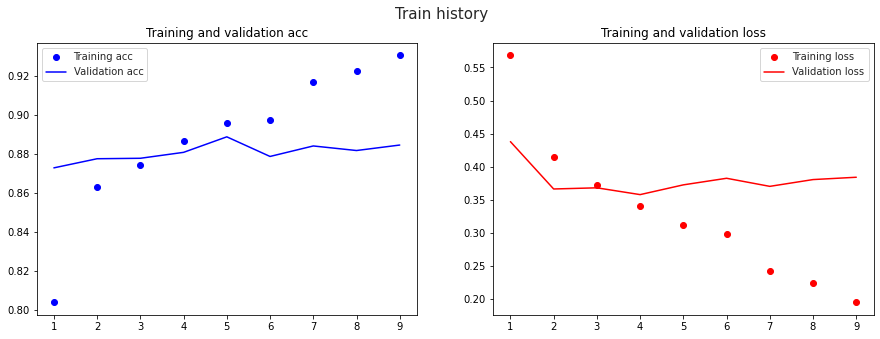

In [21]:
acc = history_list[0].history['sparse_categorical_accuracy']
val_acc = history_list[0].history['val_sparse_categorical_accuracy']
loss = history_list[0].history['loss']
val_loss = history_list[0].history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

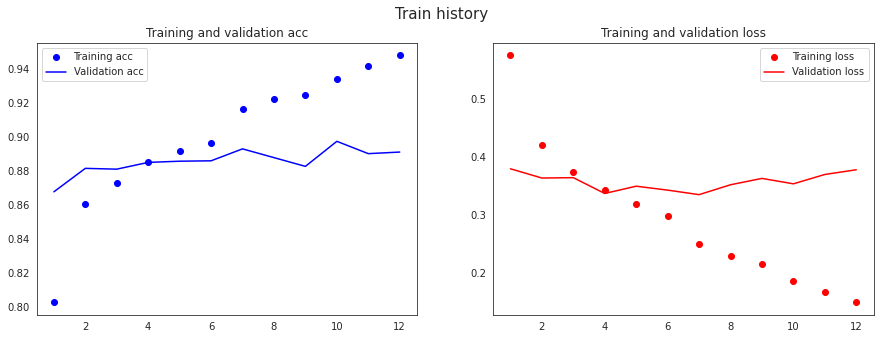

In [22]:
acc = history_list[1].history['sparse_categorical_accuracy']
val_acc = history_list[1].history['val_sparse_categorical_accuracy']
loss = history_list[1].history['loss']
val_loss = history_list[1].history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

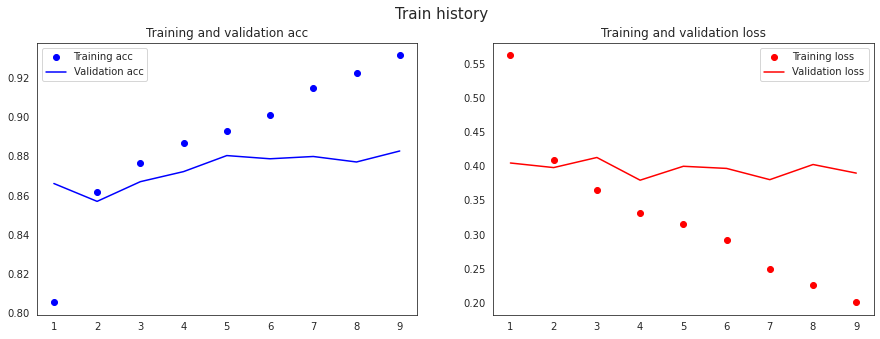

In [23]:
acc = history_list[2].history['sparse_categorical_accuracy']
val_acc = history_list[2].history['val_sparse_categorical_accuracy']
loss = history_list[2].history['loss']
val_loss = history_list[2].history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

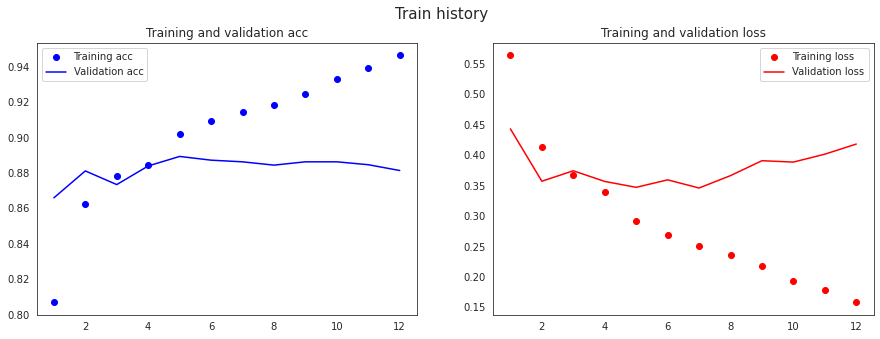

In [24]:
acc = history_list[3].history['sparse_categorical_accuracy']
val_acc = history_list[3].history['val_sparse_categorical_accuracy']
loss = history_list[3].history['loss']
val_loss = history_list[3].history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

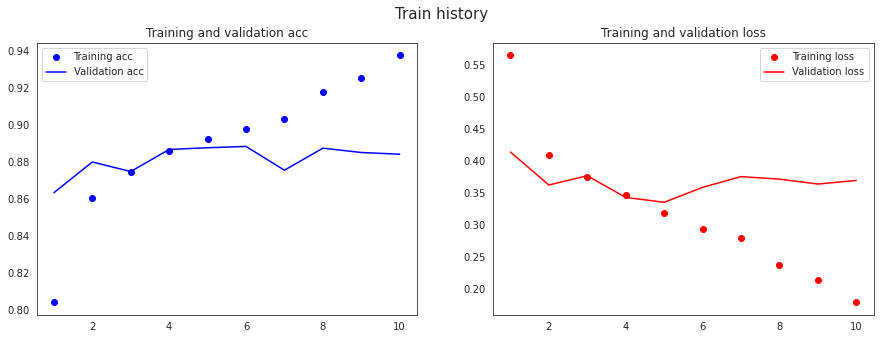

In [25]:
acc = history_list[4].history['sparse_categorical_accuracy']
val_acc = history_list[4].history['val_sparse_categorical_accuracy']
loss = history_list[4].history['loss']
val_loss = history_list[4].history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [26]:
ss['label'] = np.argmax(preds, axis = -1)
ss.to_csv('submission.csv', index = False)
ss

,image_id,label
0,2216849948.jpg,4


In [27]:
# with strategy.scope():
#     model = create_model()
    
# model.summary()

In [28]:
# print('Our EfficientNet CNN has %d layers' %len(model.layers))

In [29]:
# model_save = ModelCheckpoint('./Efnet_600_B7_best_weights_TPU.h5', 
#                              save_best_only = True, 
#                              save_weights_only = True,
#                              monitor = 'val_loss', 
#                              mode = 'min', verbose = 1)
# early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
#                            patience = 5, mode = 'min', verbose = 1,
#                            restore_best_weights = True)
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, 
#                               patience = 2, min_delta = 0.0001, 
#                               mode = 'min', verbose = 1)


# history = model.fit(
#     train_df,
#     epochs = EPOCHS,
#     steps_per_epoch = STEPS_PER_EPOCH,
#     validation_data = valid_df,
#     validation_steps = VALIDATION_STEPS,
#     callbacks = [model_save, early_stop, reduce_lr]
# )

In [30]:
# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(acc) + 1)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# sns.set_style("white")
# plt.suptitle('Train history', size = 15)

# ax1.plot(epochs, acc, "bo", label = "Training acc")
# ax1.plot(epochs, val_acc, "b", label = "Validation acc")
# ax1.set_title("Training and validation acc")
# ax1.legend()

# ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
# ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
# ax2.set_title("Training and validation loss")
# ax2.legend()

# plt.show()

In [31]:
# model.save('./EffNetB7_600_TPU.h5')

### Visualization of the first layer

In [32]:
# train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
# img_path = os.path.join(WORK_DIR, "train_images", train_labels.image_id[20])
# img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis = 0)
# img_tensor /= 255.

# plt.imshow(img_tensor[0])
# plt.axis('off')
# plt.show()

In [33]:
# activation_layer_vis(img_tensor, 0)

### Visualization of the first 3 layers

In [34]:
# all_activations_vis(img_tensor, 3)

## Prediction

In [35]:
# ss['label'] = np.argmax(model.predict(test_df), axis = -1)
# ss.to_csv('submission.csv', index = False)
# ss

## WORK IN PROGRESS...